In [1]:
import os, sys, socket
import math
import numpy as np
import scipy
import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

%config InlineBackend.figure_format ='retina'


In [2]:
matplotlib.rcParams['font.size'] = 16.0 # 22.0
matplotlib.rcParams['axes.labelsize'] = 18.0 
matplotlib.rcParams['legend.fontsize'] = 14.0 # 20.0

# Auxiliary functions

In [10]:
def probs_to_labels(pos_probs, threshold):
    
    return (pos_probs >= threshold).astype('float')


# Load saved data

In [6]:
X_train, y_train, X_test, y_test, feature_names = pickle.load( open( "data.p", "rb" ) )

In [7]:
X_train.shape, X_test.shape

((50612, 17), (18524, 17))

# Calculate permutation feature importance for ANN model
based on 
https://scikit-learn.org/stable/modules/permutation_importance.html
and
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py

In [11]:
### calculate importances using a selected subset of model features (defined by include_cols)

def ANN_permutation_importances(modelpath, Xtest, ytest, feat_names, 
                                include_cols, n_iter=10, debug=False):
    
    from sklearn.metrics import accuracy_score
    
    # Load the saved Keras model
    model = load_model(modelpath)
    model.summary()
    
    # true labels:
    true_in = ytest[:,1].copy()
    
    # baseline accuracy:
    pred_prob = model.predict(Xtest)

    # Calculate predicted probability of in-situ (second column)
    pred_prob_in = pred_prob[:,1]
    if debug: print(pred_prob_in)

    # define test sample:
    pred_in = probs_to_labels(pred_prob_in, 0.5)

    acc_full = accuracy_score(true_in, pred_in) 
    print('\nFull model accuracy =', acc_full)
    
    del pred_prob, pred_prob_in, pred_in
    
    all_cols = np.arange(0, Xtest.shape[1])
    ignore_cols = np.setdiff1d(all_cols, include_cols)
    
    # create arrays to store results:
    Ncol = len(include_cols)
    #Ncol = Xtest.shape[1]
    
    print('\nTotal/included number of features (columns):',Xtest.shape[1],'/',Ncol,',  data points:',Xtest.shape[0])
    
    acc_mean = []
    acc_std = []
    
    # shuffle indices set:
    np.random.seed(12345)
    m = Xtest.shape[0]
    shuffle_ix = np.arange(m)
    
    if debug: print('initial:\n', Xtest)
        
        
    ### shuffle highly correlated features from clustering analysis:
    Xtest_base = Xtest.copy()
    
    # shuffle columns:
    if len(ignore_cols)>0:
        
        for icol in ignore_cols:

            np.random.shuffle(shuffle_ix)
            Xtest_icol = Xtest[:,icol].copy() 
            if debug: print('col:\n', Xtest_icol)    
            Xtest_base[:,icol] = Xtest_icol[shuffle_ix]
            if debug: print('shuffled:\n', Xtest_icol[shuffle_ix])

        # make baseline predictions on test data
        pred_prob = model.predict(Xtest_base)

        # Calculate predicted probability of in-situ (second column)
        pred_prob_in = pred_prob[:,1]

        # define test sample:
        pred_in = probs_to_labels(pred_prob_in, 0.5)

        acc_base = accuracy_score(true_in, pred_in) 
        print('\nBaseline accuracy =', acc_base)

        del Xtest_icol, pred_prob, pred_prob_in, pred_in

 

    ### evaluate accuracy of model when feature icol is shuffled: 
    for icol in include_cols:
        
        print('\n permuting feature ', icol, ':', feat_names[icol])
        
        acc_samp = []
        
        for isamp in range(n_iter):
            
            Xtest_perm = Xtest_base.copy()
    
            # shuffle column:
            np.random.shuffle(shuffle_ix)
            #print(shuffle_ix)
            Xtest_icol = Xtest[:,icol].copy()
            if debug: print('col:\n', Xtest_icol)
            Xtest_perm[:,icol] = Xtest_icol[shuffle_ix]
            if debug: print('shuffled:\n', Xtest_icol[shuffle_ix])
            #print('\nafter shuffle:\n', Xtest_perm)

            # make predictions on test data
            pred_prob = model.predict(Xtest_perm)

            # Calculate predicted probability of in-situ (second column)
            pred_prob_in = pred_prob[:,1]
            #pred_prob_ex = pred_prob[:,0]

            # define test sample:
            pred_in = probs_to_labels(pred_prob_in, 0.5)

            acc_samp.append( accuracy_score(true_in, pred_in) )
            
            del Xtest_perm, Xtest_icol, pred_prob, pred_prob_in, pred_in
            
            
        if debug: print('  accuracies:', acc_samp)
                    
        acc_mean.append( np.mean(acc_samp) )
        acc_std.append( np.std(acc_samp) )
        
        print('  accuracy - mean:', acc_mean[-1], '  std:', acc_std[-1])
        
        
    if len(ignore_cols)>0:
        imp_mean = acc_base - np.array(acc_mean)
    else:
        imp_mean = acc_full - np.array(acc_mean)
    imp_std = np.array(acc_std)
    
    if debug: print('\ncheck original\n:', Xtest)
        
    ### save used feature names:
    feat_names = feat_names[include_cols]
    
    print('\nResult:\n')
    for ind in range(Ncol):
        print("{:s}".format(feat_names[ind]), '--- {:.4f}'.format(imp_mean[ind]) )
            
    return imp_mean, imp_std, feat_names


In [12]:
### plot ANN importances including ALL features:

feature_names = np.array([r'$\log M_*^{gal}$',
                 r'$\log N_{GC}$', 
                 r'$\log R_e$',
                 r'[Fe/H]$_{gal}$',
                 r'[$\alpha$/Fe]$_{gal}$',
                 r'$\sigma_{gal}$',
                 r'$\sigma$',
                 r'[Fe/H]',
                 r'[$\alpha$/Fe]',
                 r'$\Delta$[Fe/H]',
                 r'$\Delta$[$\alpha$/Fe]',
                 r'$\log R_p/R_e$',
                 r'$(|V_p|/\sigma_{gal})^{1/2}$',
                 r'$(|V_p|/\sigma)^{1/2}$',
                 r'$V_{rot}/\sigma_{gal}$', 
                 r'$\log R_p|V_p|$',
                 r'$(R_p V_{rot})^{1/3}$' ])


imp_result = ANN_permutation_importances('model.h5',  # filename of saved Keras model
                                         X_test, y_test, 
                                         feat_names=feature_names, 
                                         include_cols=np.arange(0,X_test.shape[1]),
                                         n_iter=10)


Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_315 (Dense)            (None, 50)                900       
_________________________________________________________________
dense_316 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_317 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_318 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_319 (Dense)            (None, 2)                 102       
Total params: 8,652
Trainable params: 8,652
Non-trainable params: 0
_________________________________________________________________

Full model accuracy = 0.7945368171021377

Total/included number of features (columns): 17 / 17 ,  data points: 18524

[0.00319585 0.00334701 0.00493954 0.0050799  0.00570071 0.00628374
 0.0071043  0.0098089  0.01045131 0.01161736 0.01472144 0.01518031
 0.03013388 0.04436947 0.05260203 0.06684301 0.12394191]


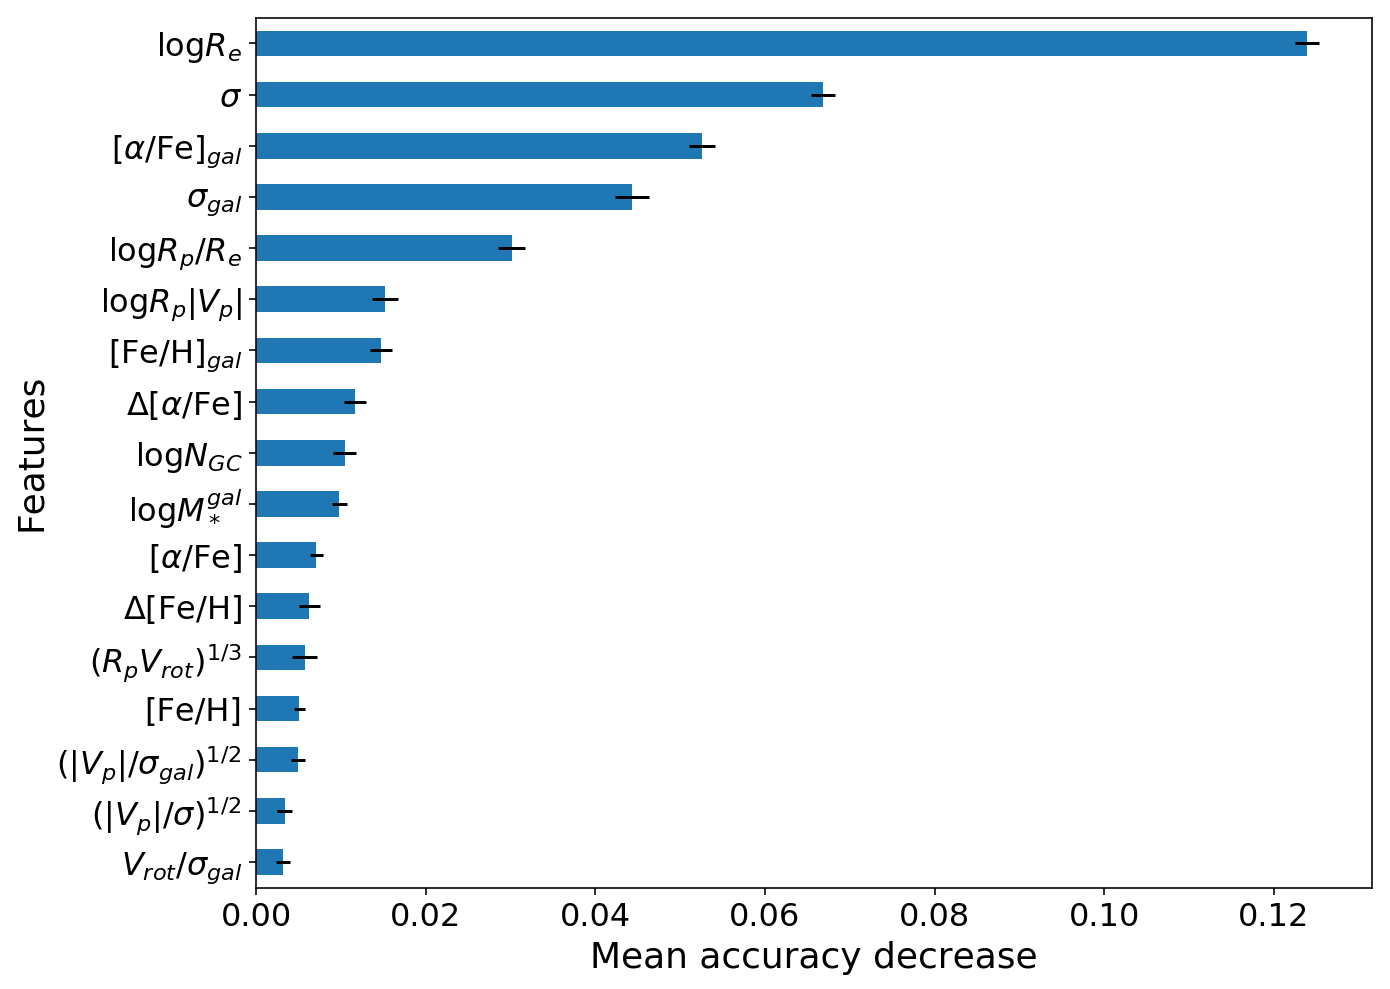

In [13]:


imp_mean = imp_result[0]
imp_std = imp_result[1]
imp_names = imp_result[2]


sorted_idx = imp_mean.argsort()
print(imp_mean[sorted_idx])


ANN_importances = pd.DataFrame({'mean': imp_mean[sorted_idx], 
                                'std': imp_std[sorted_idx]}, 
                                index=imp_names[sorted_idx])


### figure:

fig, ax = plt.subplots(figsize=(10,8))

ANN_importances.plot.barh(y='mean', xerr='std', ax=ax, legend=False)


ax.set_xlabel("Mean accuracy decrease")

ax.set_ylabel("Features")


## Test effect of masking covariant features in existing model (not recommended)

In [114]:
### select set of non-covariant features from analysis below

col_mask = [4,0,2,15,10,11,9,12,14]


[(i, feature_names[col_mask][i]) for i in range(len(feature_names[col_mask]))]

[(0, '[$\\alpha$/Fe]$_{gal}$'),
 (1, '$\\log M_*^{gal}$'),
 (2, '$\\log R_e$'),
 (3, '$\\log R_p|V_p|$'),
 (4, '$\\Delta$[$\\alpha$/Fe]'),
 (5, '$\\log R_p/R_e$'),
 (6, '$\\Delta$[Fe/H]'),
 (7, '$(|V_p|/\\sigma_{gal})^{1/2}$'),
 (8, '$V_{rot}/\\sigma_{gal}$')]

In [115]:
### calculate importances

feature_names = np.array([r'$\log M_*^{gal}$',
                 r'$\log N_{GC}$', 
                 r'$\log R_e$',
                 r'[Fe/H]$_{gal}$',
                 r'[$\alpha$/Fe]$_{gal}$',
                 r'$\sigma_{gal}$',
                 r'$\sigma$',
                 r'[Fe/H]',
                 r'[$\alpha$/Fe]',
                 r'$\Delta$[Fe/H]',
                 r'$\Delta$[$\alpha$/Fe]',
                 r'$\log R_p/R_e$',
                 r'$(|V_p|/\sigma_{gal})^{1/2}$',
                 r'$(|V_p|/\sigma)^{1/2}$',
                 r'$V_{rot}/\sigma_{gal}$', 
                 r'$\log R_p|V_p|$',
                 r'$(R_p V_{rot})^{1/3}$' ])


imp_result = ANN_permutation_importances('model.h5',   # filename of saved Keras model
                                         X_test, y_test, 
                                         feat_names=feature_names, 
                                         include_cols=[4,0,2,15,10,11,9,12,14],
                                         n_iter=10)


Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_315 (Dense)            (None, 50)                900       
_________________________________________________________________
dense_316 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_317 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_318 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_319 (Dense)            (None, 2)                 102       
Total params: 8,652
Trainable params: 8,652
Non-trainable params: 0
_________________________________________________________________

Full model accuracy = 0.7945368171021377

Total/included number of features (columns): 17 / 9 ,  data points: 18524


[-0.00062082  0.00106888  0.00141438  0.008794    0.01826279  0.02352624
  0.02653854  0.03250378  0.06591989]


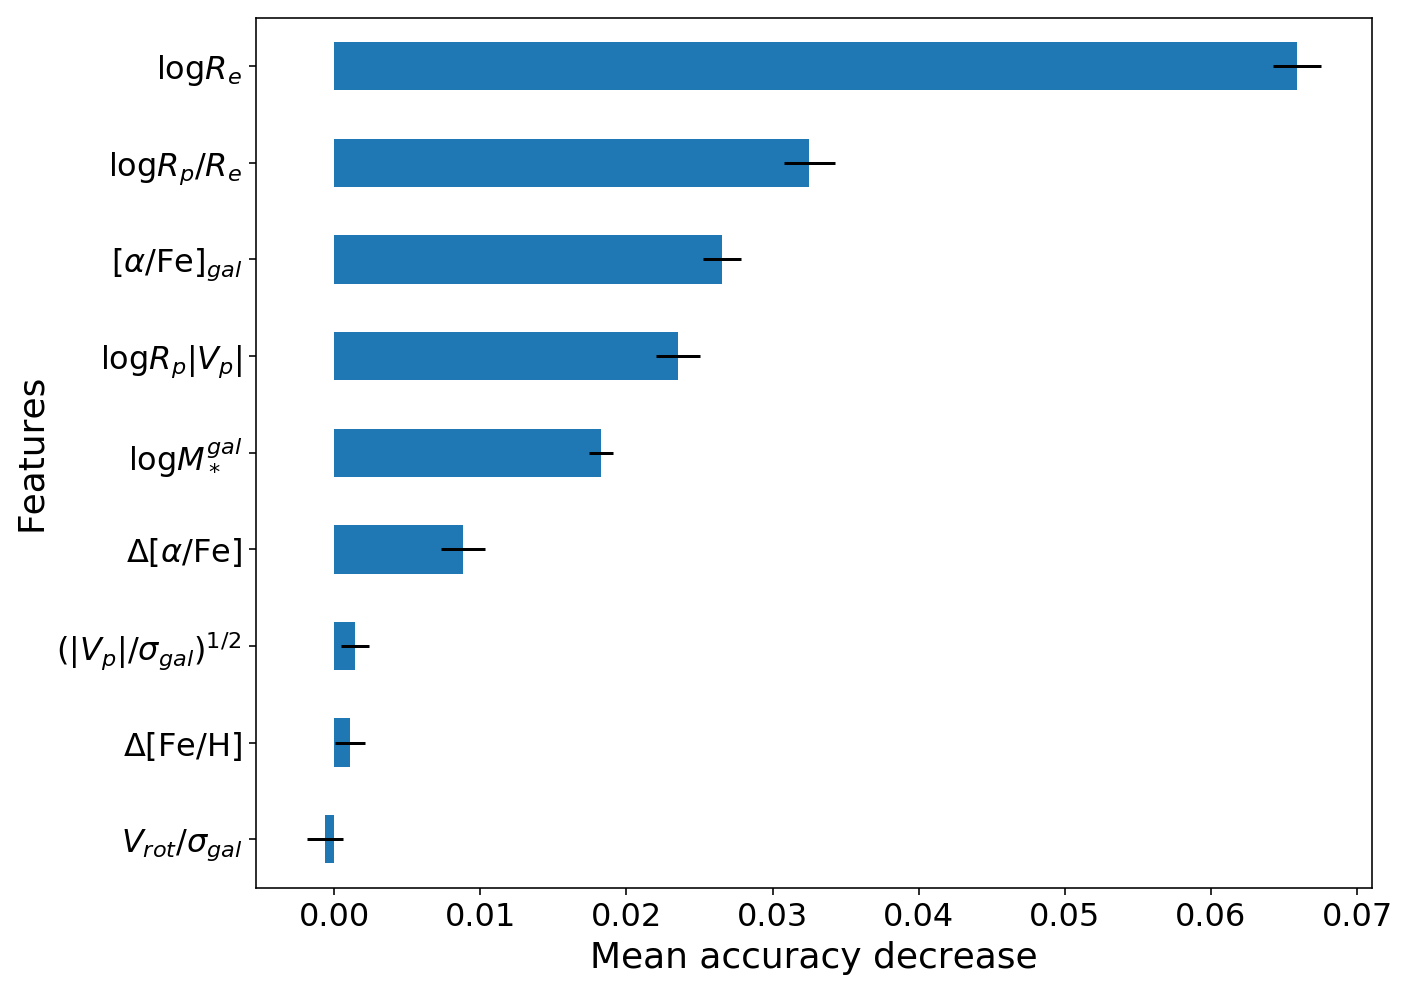

In [116]:
### plot ANN importances after removing covariant features in clusters:

imp_mean = imp_result[0]
imp_std = imp_result[1]
imp_names = imp_result[2]


sorted_idx = imp_mean.argsort()
print(imp_mean[sorted_idx])


ANN_importances = pd.DataFrame({'mean': imp_mean[sorted_idx], 
                                'std': imp_std[sorted_idx]}, 
                                index=imp_names[sorted_idx])


### figure:

fig, ax = plt.subplots(figsize=(10,8))

ANN_importances.plot.barh(y='mean', xerr='std', ax=ax, legend=False)


ax.set_xlabel("Mean accuracy decrease")

ax.set_ylabel("Features")


# Check feature covariance using clustering analysis

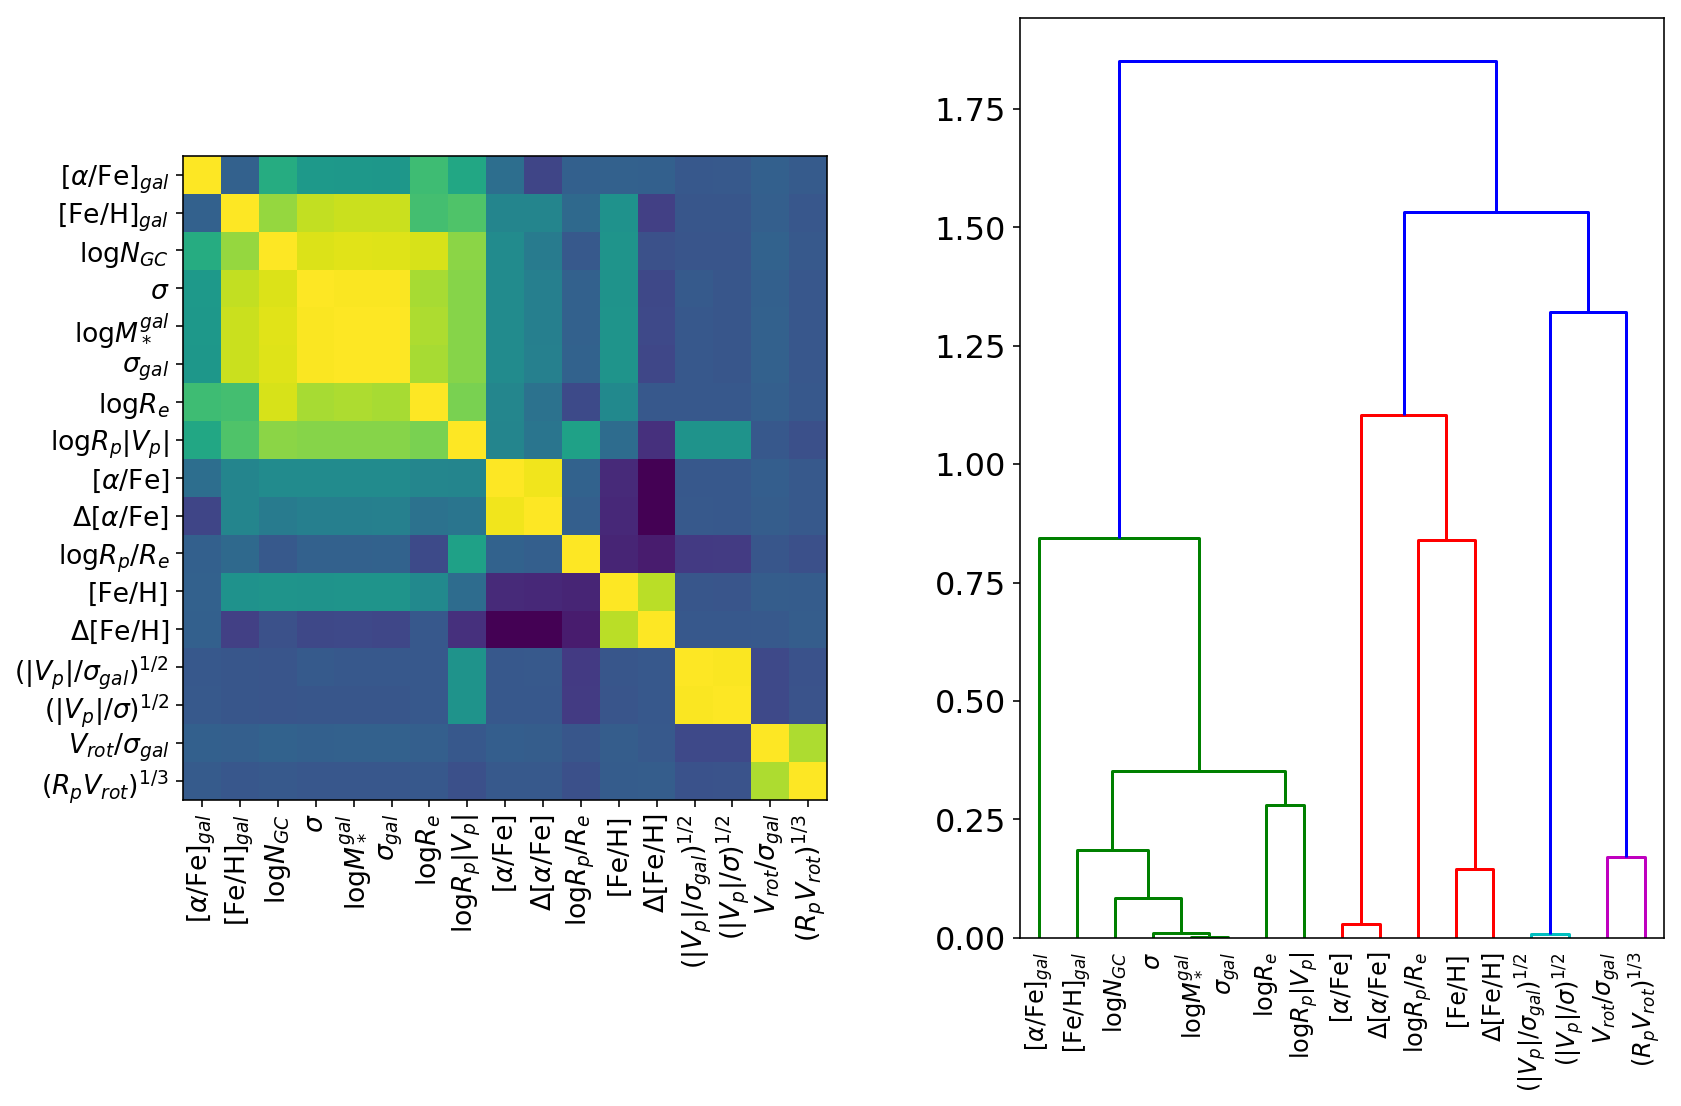

In [25]:
### check effect of feature cross-correlation on importances of FULL model:

from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform



fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X_test).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(dist_linkage, labels=feature_names.tolist(), ax=ax1, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical", fontsize='small')
ax2.set_yticklabels(dendro["ivl"], fontsize='small')
fig.tight_layout()

plt.subplots_adjust(wspace=0.3)


## Remove covariant features with distance < 0.2 in dendrogram

In [61]:
### list all features:

[(i, feature_names[i]) for i in range(len(feature_names))]

[(0, '$\\log M_*^{gal}$'),
 (1, '$\\log N_{GC}$'),
 (2, '$\\log R_e$'),
 (3, '[Fe/H]$_{gal}$'),
 (4, '[$\\alpha$/Fe]$_{gal}$'),
 (5, '$\\sigma_{gal}$'),
 (6, '$\\sigma$'),
 (7, '[Fe/H]'),
 (8, '[$\\alpha$/Fe]'),
 (9, '$\\Delta$[Fe/H]'),
 (10, '$\\Delta$[$\\alpha$/Fe]'),
 (11, '$\\log R_p/R_e$'),
 (12, '$(|V_p|/\\sigma_{gal})^{1/2}$'),
 (13, '$(|V_p|/\\sigma)^{1/2}$'),
 (14, '$V_{rot}/\\sigma_{gal}$'),
 (15, '$\\log R_p|V_p|$'),
 (16, '$(R_p V_{rot})^{1/3}$')]

In [62]:
### select features based on clustering analysis

col_mask = [4,0,2,15,10,11,9,12,14]


[(i, feature_names[col_mask][i]) for i in range(len(feature_names[col_mask]))]

[(0, '[$\\alpha$/Fe]$_{gal}$'),
 (1, '$\\log M_*^{gal}$'),
 (2, '$\\log R_e$'),
 (3, '$\\log R_p|V_p|$'),
 (4, '$\\Delta$[$\\alpha$/Fe]'),
 (5, '$\\log R_p/R_e$'),
 (6, '$\\Delta$[Fe/H]'),
 (7, '$(|V_p|/\\sigma_{gal})^{1/2}$'),
 (8, '$V_{rot}/\\sigma_{gal}$')]

In [63]:
### select features:

X_train = X_train[:,col_mask].copy()
X_test = X_test[:,col_mask].copy()

feature_names = feature_names[col_mask]

# Train and save a new model with covariant features removed


Testing model with 9 features, 4 layers and 50 nodes per layer...

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 50)                500       
_________________________________________________________________
dense_26 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_27 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_28 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 102       
Total params: 8,252
Trainable params: 8,252
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1582/1582 [===========================

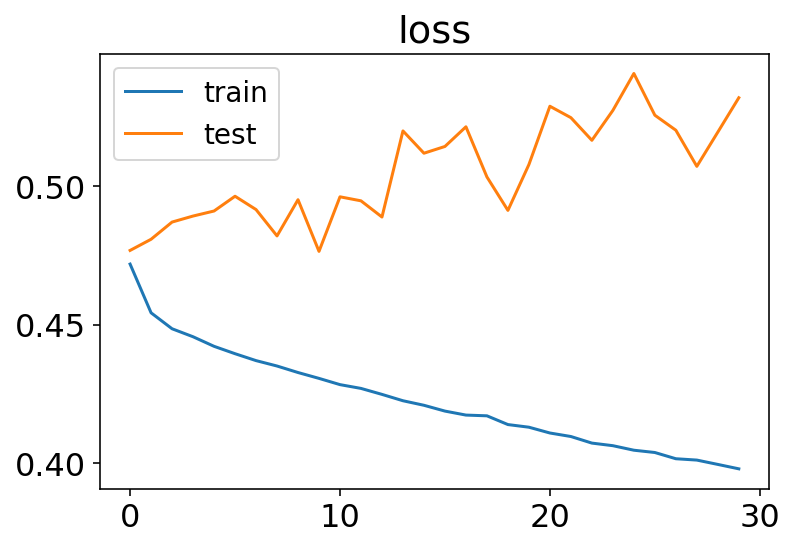

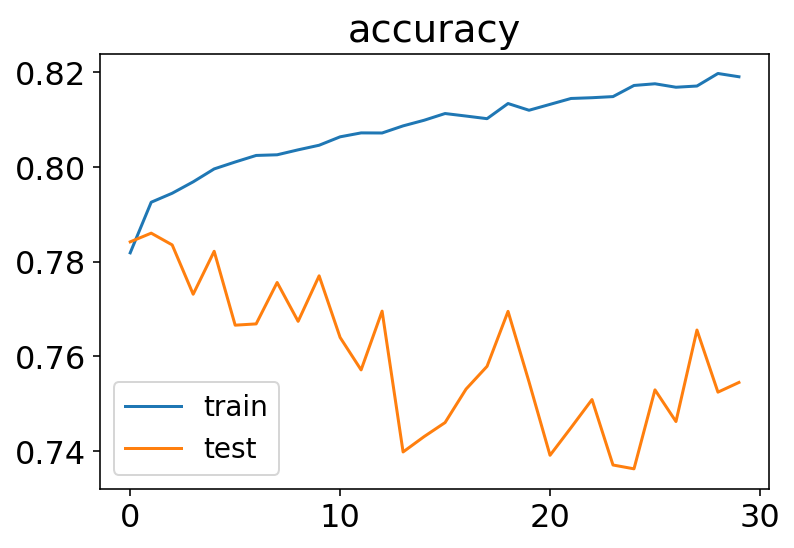

In [65]:
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical



### Define and save the best perfoming model

N_nodes = 50  # same values as initial model
N_layers = 4

# Save the number of columns in predictors: n_cols
n_cols = X_train.shape[1]


print('\nTesting model with '+str(n_cols)+' features, '+str(N_layers)+' layers and '+str(N_nodes)+' nodes per layer...\n')


# Create the model: model
model = Sequential()

# Add the first hidden layer
model.add(Dense(N_nodes, activation='relu', input_shape = (n_cols,)))

# Add the other hidden layers
for k in range(N_layers-1):
    model.add(Dense(N_nodes, activation='relu'))

# Add the output layer
model.add(Dense(y_train.shape[1], activation='sigmoid'))

model.summary()



# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping_monitor = EarlyStopping(patience=20)


# Fit and save the model
best_model = 'model_reducedcovariance.h5'

result = model.fit(X_train, y_train, 
                   epochs=100, 
                   validation_data=(X_test,y_test),
                   callbacks=[early_stopping_monitor,
                              ModelCheckpoint(filepath=best_model, monitor='val_loss', save_best_only=True)], 
                   verbose=1)


#print('\naccuracy history:', result.history['val_accuracy'])

train_score = np.max(result.history['accuracy'])
val_score = np.max(result.history['val_accuracy'])


print('\nbest train score:', train_score)
print('best validation score:', val_score)


# plot loss during training
plt.figure()
plt.title('loss')
plt.plot(result.history['loss'], label='train')
plt.plot(result.history['val_loss'], label='test')
plt.legend()

# plot accuracy during training
plt.figure()
plt.title('accuracy')
plt.plot(result.history['accuracy'], label='train')
plt.plot(result.history['val_accuracy'], label='test')
plt.legend()


# Calculate feature importances in new reduced model

In [67]:
### importances using use all features

def ANN_permutation_importances_all(modelpath, Xtest, ytest, feat_names, n_iter=10, debug=False):
    
    from sklearn.metrics import accuracy_score
    
    # Load the saved model
    model = load_model(modelpath)
    model.summary()
    
    # true labels:
    true_in = ytest[:,1].copy()
    
    # baseline accuracy:
    pred_prob = model.predict(Xtest)

    # Calculate predicted probability of in-situ (second column)
    pred_prob_in = pred_prob[:,1]
    if debug: print(pred_prob_in)

    # define test sample:
    pred_in = probs_to_labels(pred_prob_in, 0.5)

    acc_baseline = accuracy_score(true_in, pred_in) 
    print('\nBaseline accuracy =', acc_baseline)
    
    
    # create arrays:
    Ncol = Xtest.shape[1]
    
    print('\nNumber of features (columns):', Ncol, '  data points:', Xtest.shape[0])
    
    acc_mean = np.zeros(Ncol)
    acc_std = np.zeros(Ncol)
    
    # shuffle indices set:
    np.random.seed(12345)
    m = Xtest.shape[0]
    shuffle_ix = np.arange(m)
    
    if debug: print('initial:\n', Xtest)
    
 
    for icol in range(Ncol):
        
        print('\n permuting feature ', icol, ':', feat_names[icol])
        
        acc_samp = []
        
        for isamp in range(n_iter):
            
            Xtest_perm = Xtest.copy()
    
            # shuffle column:
            np.random.shuffle(shuffle_ix)
            #print(shuffle_ix)
            Xtest_icol = Xtest[:,icol].copy()
            if debug: print('col:\n', Xtest_icol)
            Xtest_perm[:,icol] = Xtest_icol[shuffle_ix]
            if debug: print('shuffled:\n', Xtest_icol[shuffle_ix])
            #print('\nafter shuffle:\n', Xtest_perm)

            # make predictions on test data
            pred_prob = model.predict(Xtest_perm)

            # Calculate predicted probability of in-situ (second column)
            pred_prob_in = pred_prob[:,1]
            #pred_prob_ex = pred_prob[:,0]

            # define test sample:
            pred_in = probs_to_labels(pred_prob_in, 0.5)

            acc_samp.append( accuracy_score(true_in, pred_in) )
            
            del Xtest_perm, Xtest_icol, pred_prob, pred_prob_in, pred_in
            
            
        if debug: print('  accuracies:', acc_samp)
                    
        acc_mean[icol] = np.mean(acc_samp)
        acc_std[icol] = np.std(acc_samp)
        
        print('  acc mean:', acc_mean[icol], '  acc std:', acc_std[icol])
        
        
    imp_mean = acc_baseline - acc_mean
    imp_std = acc_std
    
    if debug: print('\ncheck original\n:', Xtest)
    
    print('\nResult:\n')
    for ind in range(Ncol):
        print(feat_names[ind], '--- {:.4f}'.format(imp_mean[ind]) )
            
    return imp_mean, acc_std


In [68]:

imp_result = ANN_permutation_importances_all(
                'modelreducedcovariance.h5',
                 X_test, y_test, 
                 feat_names=feature_names, 
                 n_iter=30)


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 50)                500       
_________________________________________________________________
dense_26 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_27 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_28 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 102       
Total params: 8,252
Trainable params: 8,252
Non-trainable params: 0
_________________________________________________________________

Baseline accuracy = 0.7770459943856618

Number of features (columns): 9   data points: 18524

 permuting feature  0 :

[ 0.04909667  0.05076117  0.10053984  0.0216188   0.02214604  0.01604585
  0.02552365  0.00186245 -0.00014036] [0.00173975 0.00201408 0.002623   0.00123471 0.00173202 0.00135367
 0.00153131 0.00080733 0.000577  ]
[-0.00014036  0.00186245  0.01604585  0.0216188   0.02214604  0.02552365
  0.04909667  0.05076117  0.10053984]


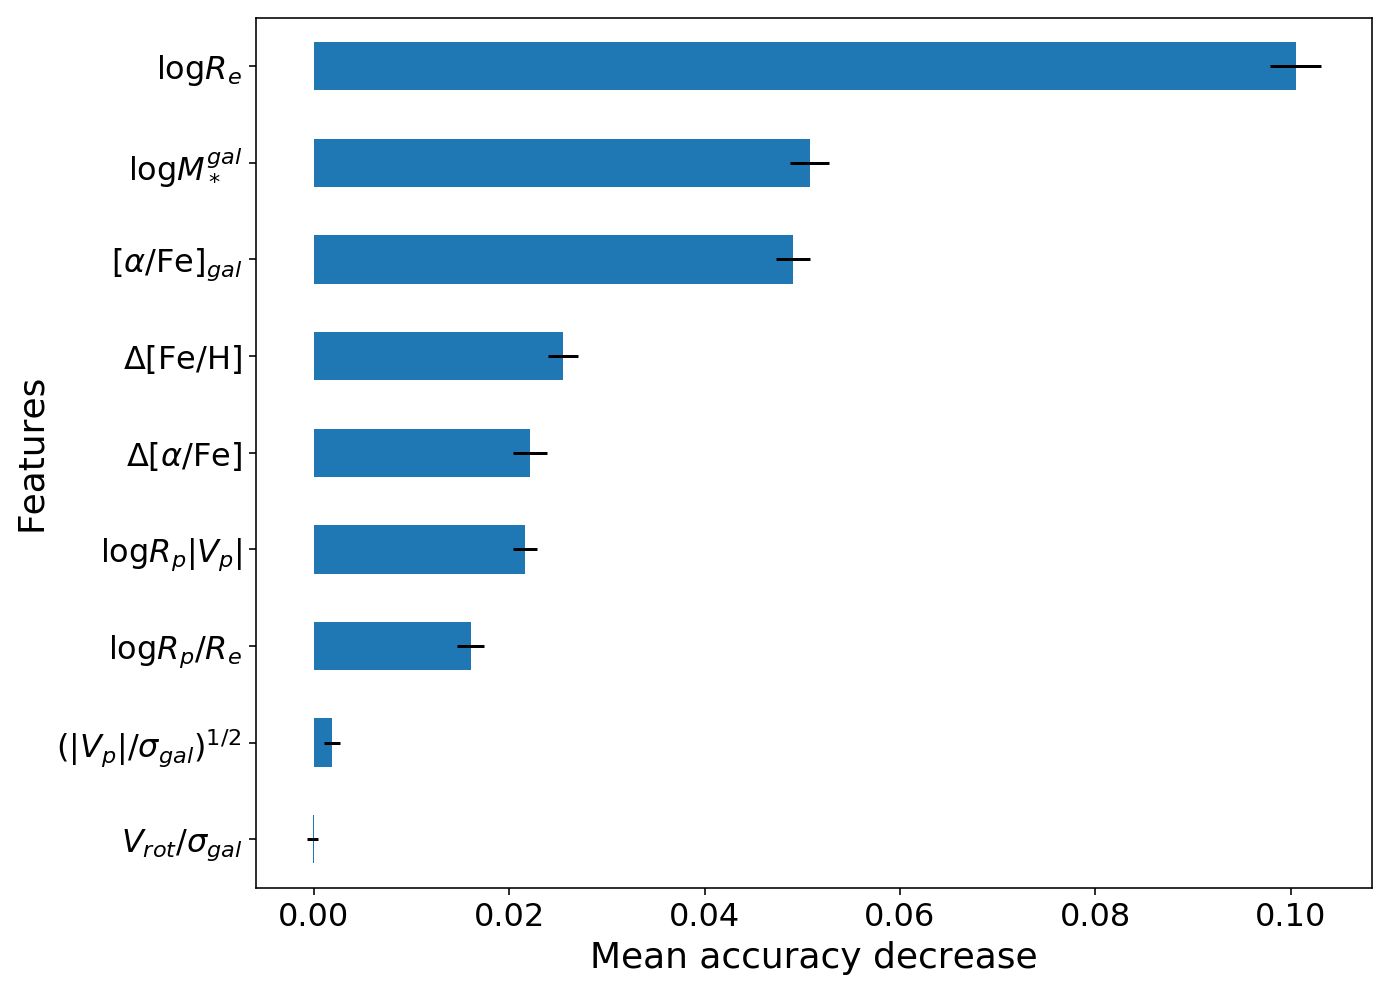

In [71]:
### plot ANN importances:

imp_mean = imp_result[0]
imp_std = imp_result[1]
print(imp_mean, imp_std)

sorted_idx = imp_mean.argsort()
print(imp_mean[sorted_idx])


ANN_importances = pd.DataFrame({'mean': imp_mean[sorted_idx], 
                                'std': imp_std[sorted_idx]}, 
                                index=feature_names[sorted_idx])



### figure:

fig, ax = plt.subplots(figsize=(10,8))

ANN_importances.plot.barh(y='mean', xerr='std', ax=ax, legend=False)


ax.set_xlabel("Mean accuracy decrease")

ax.set_ylabel("Features")
